<a href="https://colab.research.google.com/github/tomasdfen/AADLIS/blob/main/AADLIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 1.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
%load_ext tensorboard

import os
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

TEST_PERCENTAGE = 0.2
VAL_PERCENTAGE = 0.1
LAG = 30
PREDICT_WINDOW=20
plt.rcParams["figure.figsize"] = (16,8)

In [3]:
def preprocess(dataset : pd.DataFrame, lag : int = 15, predict_window : int = 20, feature_range = (-1,1)):
    assert predict_window >= 1, "predict_window has to be higher or equal than 1"

    temp = dataset.values.copy()
    temp_x = np.zeros((temp.shape[0]-(lag+predict_window), lag, temp.shape[1]))
    temp_y = temp[lag+predict_window:,:]
    scaler = MinMaxScaler(feature_range=feature_range).fit(dataset)
    for i in range(lag):
       temp_x[:,i,:] = scaler.transform(temp[i:-(lag+predict_window-i),:])
    return temp_x, temp_y

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Datos.xlsx', parse_dates=True, index_col=0).resample("S").mean().interpolate()
print(df.shape)
df.head()

(42481, 24)


,AFN01,AFN02,AFN03,AFN04,AFN05,AFN06,AFN07,AFN08,AFN09,AFN10,AFN11,AFN12,AFN13,AFN14,AFN15,AFN16,AFN17,AFN18,AFN19,AFN20,AFN21,AFN22,AFN23,AFN24
Time (hh:mm:ss.ms),,,,,,,,,,,,,,,,,,,,,,,,
2021-03-04 05:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-04 05:55:01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-04 05:55:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-04 05:55:03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-04 05:55:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#df2 = df.resample("S").mean().interpolate()
#print(df2.shape)
#df2.head()

In [ ]:
#df3 = df.resample("0.5S").mean().interpolate()
#print(df3.shape)
#df3.head()

## Tratando datos regularizados a 1 segundo

In [5]:
test_cutoff_date = df.index[int(len(df.index)* (1 - TEST_PERCENTAGE - VAL_PERCENTAGE))]
val_cutoff_date = df.index[int(len(df.index) * (1 - VAL_PERCENTAGE))]

In [6]:
train = df.loc[:test_cutoff_date]
test = df.loc[test_cutoff_date:val_cutoff_date]
val = df.loc[val_cutoff_date:]

In [7]:
x_train, y_train = preprocess(train, lag = LAG, predict_window=PREDICT_WINDOW)
x_test, y_test = preprocess(test, lag = LAG, predict_window=PREDICT_WINDOW)
x_val,y_val = preprocess(val, lag = LAG, predict_window=PREDICT_WINDOW)
val_data = (x_val, y_val)
del df

In [8]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = TensorBoard(logdir, histogram_freq=1)
ea = EarlyStopping()

In [9]:
def root_mean_squared_error(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [10]:
model = Sequential()
model.add(Input((LAG,24)))
model.add(LSTM(32))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(24, activation='linear'))

model.compile(loss=root_mean_squared_error, optimizer = "SGD", metrics=["mse", "mape"])

1 epoch, batch_size = 32, loss: 630.1562 - mse: 419101.3912 - mape: 68665045.7788 - val_loss: 392.9393 - val_mse: 240578.7969 - val_mape: 21970810.0000

In [11]:
model.fit(x=x_train, y=y_train,epochs=1, batch_size = 32, validation_data=val_data, callbacks=[ea, tb])

928/928 [==============================] - 15s 14ms/step - loss: 630.1562 - mse: 419101.3912 - mape: 68665045.7788 - val_loss: 392.9393 - val_mse: 240578.7969 - val_mape: 21970810.0000


In [17]:
model.save(f'/content/drive/MyDrive/modelo_fachero_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')

5452.079536825799


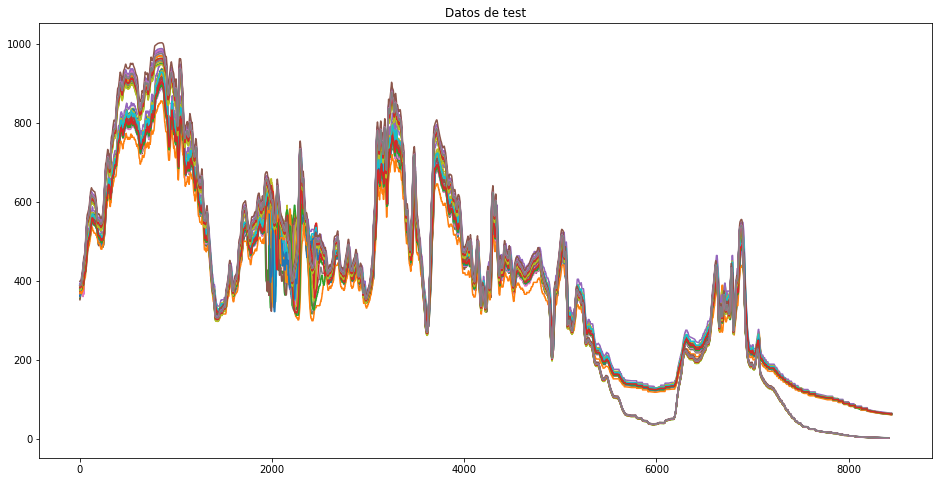

In [15]:
predicts = model.predict(x=x_test)
print(mean_squared_error(predicts, y_test))
plt.title('Datos de test')
plt.plot(range(len(y_test)),y_test )
plt.plot(range(len(predicts[PREDICT_WINDOW:])),predicts[PREDICT_WINDOW:] )
plt.show()

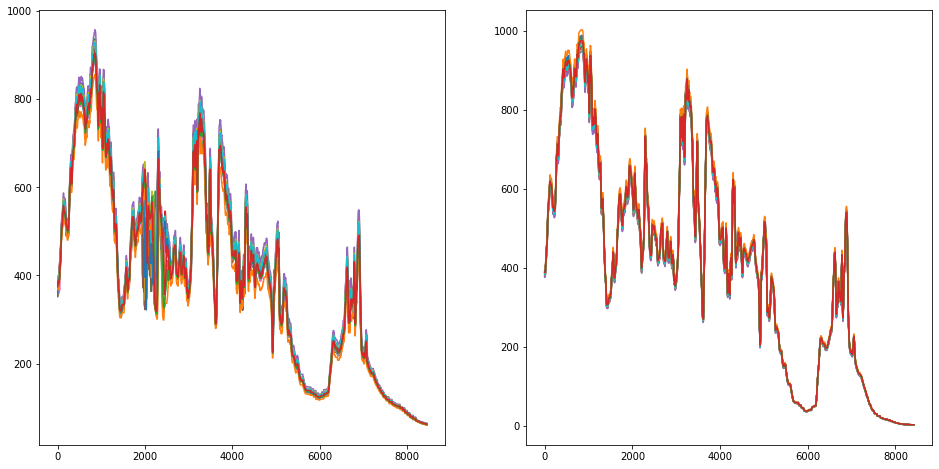

<Figure size 2880x576 with 0 Axes>

In [16]:
fig, axs = plt.subplots(1,2)
axs[0].plot(range(len(y_test)),y_test )
axs[1].plot(range(len(predicts[PREDICT_WINDOW:])),predicts[PREDICT_WINDOW:] )
plt.figure(figsize=(40,8))
plt.show()

In [18]:
forest = RandomForestRegressor(n_estimators=100, criterion="mse")
forest.fit(X = x_train.reshape(-1, LAG*24), y = y_train)

RandomForestRegressor()

14639.220851373708


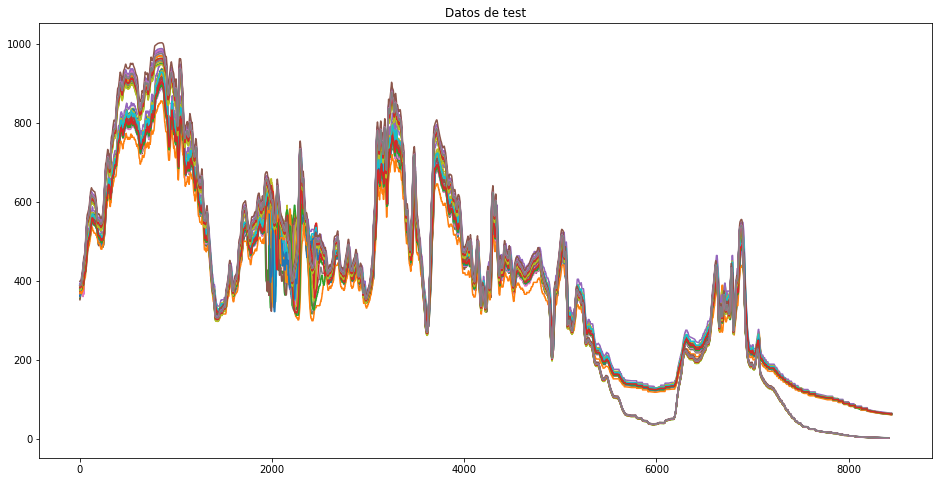

In [22]:
predictsf = forest.predict(x_test.reshape(-1,LAG*24))
print(mean_squared_error(predictsf, y_test))
plt.title('Datos de test')
plt.plot(range(len(y_test)),y_test )
plt.plot(range(len(predictsf[LAG:])),predicts[LAG:] )
plt.show()

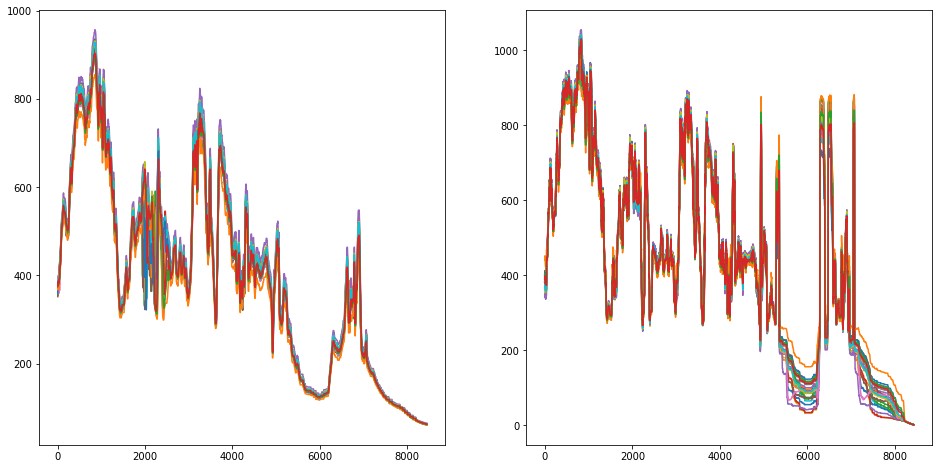

<Figure size 2880x576 with 0 Axes>

In [24]:
fig, axs = plt.subplots(1,2)
axs[0].plot(range(len(y_test)),y_test )
axs[1].plot(range(len(predictsf[PREDICT_WINDOW:])),predictsf[PREDICT_WINDOW:] )
plt.figure(figsize=(40,8))
plt.show()

In [19]:
import pickle
filename = '/content/drive/MyDrive/modelo_arbol.sav'
pickle.dump(forest, open(filename, 'wb'))